⚡ Using mps
📂 Train samples: 5710 | Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
📂 Test samples : 1309 | Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
🚀 Using EfficientNet-B7 Pretrained Backbone (feature_extraction)


Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /Users/muhammadmuhtasimshahriar/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth


100%|██████████| 255M/255M [00:44<00:00, 6.03MB/s] 

🚀 Training EfficientNet-B7...
[Epoch 01] LR=1.00e-04 | Train Acc=0.6748, Test Acc=0.7571 | Train Loss=1.0948, Test Loss=0.9529 | Test F1=0.7192
💾 New Best Model (F1): 0.7192 at Epoch 1
[Epoch 02] LR=1.00e-04 | Train Acc=0.7697, Test Acc=0.7846 | Train Loss=0.8753, Test Loss=0.8219 | Test F1=0.7577
💾 New Best Model (F1): 0.7577 at Epoch 2
[Epoch 03] LR=1.00e-04 | Train Acc=0.7832, Test Acc=0.7937 | Train Loss=0.8135, Test Loss=0.7741 | Test F1=0.7693
💾 New Best Model (F1): 0.7693 at Epoch 3
[Epoch 04] LR=1.00e-04 | Train Acc=0.7884, Test Acc=0.8067 | Train Loss=0.7902, Test Loss=0.7481 | Test F1=0.7849
💾 New Best Model (F1): 0.7849 at Epoch 4
[Epoch 05] LR=1.00e-04 | Train Acc=0.7963, Test Acc=0.8105 | Train Loss=0.7639, Test Loss=0.7357 | Test F1=0.7888
💾 New Best Model (F1): 0.7888 at Epoch 5
[Epoch 06] LR=1.00e-04 | Train Acc=0.8200, Test Acc=0.8113 | Train Loss=0.7354, Test Loss=0.7250 | Test F1=0.7898
💾 New Best Model (F1): 0.789

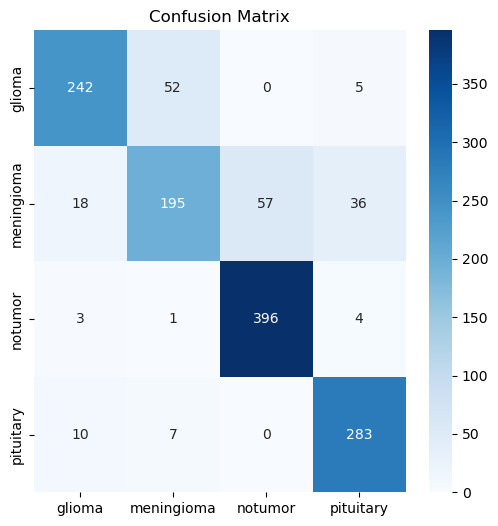

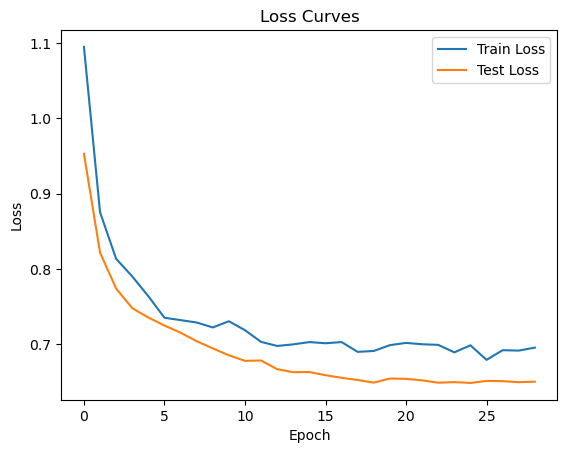

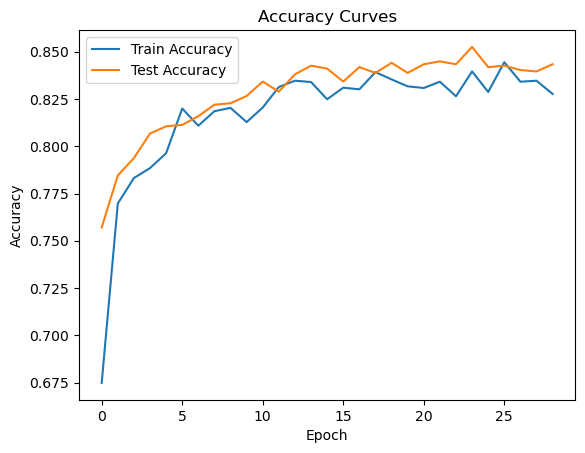

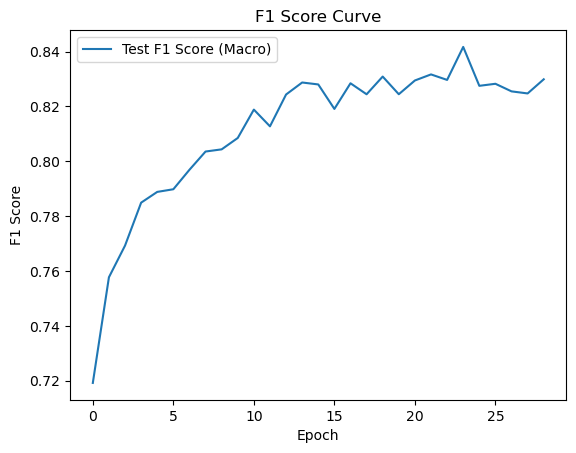

In [2]:
import os, time, warnings, logging
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =====================
# SETTINGS
# =====================
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

DEVICE = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
logger.info(f"⚡ Using {DEVICE}")

BATCH_SIZE = 8        # smaller batch (B7 is very heavy)
EPOCHS = 50
IMG_SIZE = 380        # B7 default is 600, but use 380 on Mac for speed
PATIENCE = 5
MODE = "feature_extraction"   # "feature_extraction" or "fine_tune"

TRAIN_DIR = r'/Users/muhammadmuhtasimshahriar/Downloads/archive/Training'
TEST_DIR  = r'/Users/muhammadmuhtasimshahriar/Downloads/archive/Testing'

# =====================
# DATA TRANSFORMS
# =====================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =====================
# DATASETS
# =====================
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=test_transform)

logger.info(f"📂 Train samples: {len(train_dataset)} | Classes: {train_dataset.classes}")
logger.info(f"📂 Test samples : {len(test_dataset)} | Classes: {test_dataset.classes}")

num_classes = len(train_dataset.classes)

# Balanced sampler
class_counts = np.bincount(train_dataset.targets)
class_weights = 1. / class_counts
samples_weight = [class_weights[t] for t in train_dataset.targets]
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# =====================
# MODEL: EfficientNet-B7
# =====================
logger.info(f"🚀 Using EfficientNet-B7 Pretrained Backbone ({MODE})")
model = models.efficientnet_b7(weights="IMAGENET1K_V1")
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

# -------- MODE Handling --------
if MODE == "feature_extraction":
    for param in model.features.parameters():
        param.requires_grad = False
    params_to_update = model.classifier.parameters()
    LR = 1e-4
elif MODE == "fine_tune":
    for param in model.parameters():
        param.requires_grad = True
    params_to_update = model.parameters()
    LR = 1e-5

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(params_to_update, lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=3, factor=0.3
)

model = model.to(DEVICE)

# =====================
# TRAINING LOOP
# =====================
best_f1, best_acc = 0, 0
best_f1_epoch, best_acc_epoch = 0, 0
patience_counter = 0

train_acc_list, test_acc_list, train_loss_list, test_loss_list, f1_list = [], [], [], [], []

start_time = time.time()
logger.info("\n🚀 Training EfficientNet-B7...")

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = total_loss / len(train_loader)

    # ---- Eval ----
    model.eval()
    y_true, y_pred = [], []
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    test_loss /= len(test_loader)
    test_f1 = f1_score(y_true, y_pred, average="macro")

    # Save history
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    f1_list.append(test_f1)

    scheduler.step(test_f1)
    lr = optimizer.param_groups[0]['lr']

    logger.info(f"[Epoch {epoch+1:02d}] LR={lr:.2e} | "
                f"Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f} | "
                f"Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f} | "
                f"Test F1={test_f1:.4f}")

    # Track best F1
    if test_f1 > best_f1:
        best_f1 = test_f1
        best_f1_epoch = epoch + 1
        patience_counter = 0
        torch.save(model.state_dict(), f"best_efficientnet_b7_{MODE}.pth")
        logger.info(f"💾 New Best Model (F1): {best_f1:.4f} at Epoch {best_f1_epoch}")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            logger.info("⏹ Early stopping triggered.")
            break

    # Track best Accuracy
    if test_acc > best_acc:
        best_acc = test_acc
        best_acc_epoch = epoch + 1

elapsed = (time.time()-start_time)/60
logger.info(f"\n⏱ Training finished in {elapsed:.1f} min.")

# =====================
# LOAD BEST MODEL
# =====================
model.load_state_dict(torch.load(f"best_efficientnet_b7_{MODE}.pth"))
model.eval()
logger.info("🔄 Loaded best saved EfficientNet-B7 model for evaluation.")

# =====================
# FINAL EVALUATION
# =====================
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

final_acc = accuracy_score(y_true, y_pred)
final_prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
final_rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
final_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

logger.info("\n📊 FINAL PERFORMANCE SUMMARY")
logger.info("===================================")
logger.info(f"✅ Accuracy         : {final_acc*100:.2f}%")
logger.info(f"🎯 Precision (Macro): {final_prec:.4f}")
logger.info(f"📌 Recall    (Macro): {final_rec:.4f}")
logger.info(f"📈 F1-Score  (Macro): {final_f1:.4f}")

logger.info("\n🏆 BEST EPOCH METRICS")
logger.info("===================================")
logger.info(f"📌 Highest Test Accuracy : {best_acc*100:.2f}% at Epoch {best_acc_epoch}")
logger.info(f"📌 Highest Test F1-Score : {best_f1:.4f} at Epoch {best_f1_epoch}")

# =====================
# CONFUSION MATRIX
# =====================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes,
            cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# =====================
# TRAINING CURVES
# =====================
plt.figure()
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.show()

plt.figure()
plt.plot(f1_list, label="Test F1 Score (Macro)")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score Curve")
plt.legend()
plt.show()